In [1]:
import torch
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torch import optim
from torch.utils.data import TensorDataset
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import copy

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def create_class_dict(csv_path):
    class_dict = {}
    with open(csv_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            class_dict[int(row['id'])] = row['category']
    return class_dict

class_dict = create_class_dict("activity_categories.csv")

In [6]:
def load_images_from_folder(folder, target_size=(128,128)):
    images=[]
    img_ids=[]
    for filename in sorted(os.listdir(folder),key=lambda x: int(x.split(".")[0])):
        idx = filename.split(".")[0]
        img_ids.append(idx)

        img_path = os.path.join(folder,filename)
        img  = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,target_size) 
        img = img / 255.0
        images.append(img)

    return np.array(images),img_ids

X_train,img_ids = load_images_from_folder("img_train")

In [50]:
df = pd.read_csv("train_answers.csv", sep=";")
df["img_id"] = df["img_id"].astype(str)

id_to_label = dict(zip(df["img_id"], df["target_feature"]))

le = LabelEncoder()

y_train = le.fit_transform(np.array([id_to_label[img_id] for img_id in img_ids]))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (12367, 128, 128, 3)
y_train shape: (12367,)


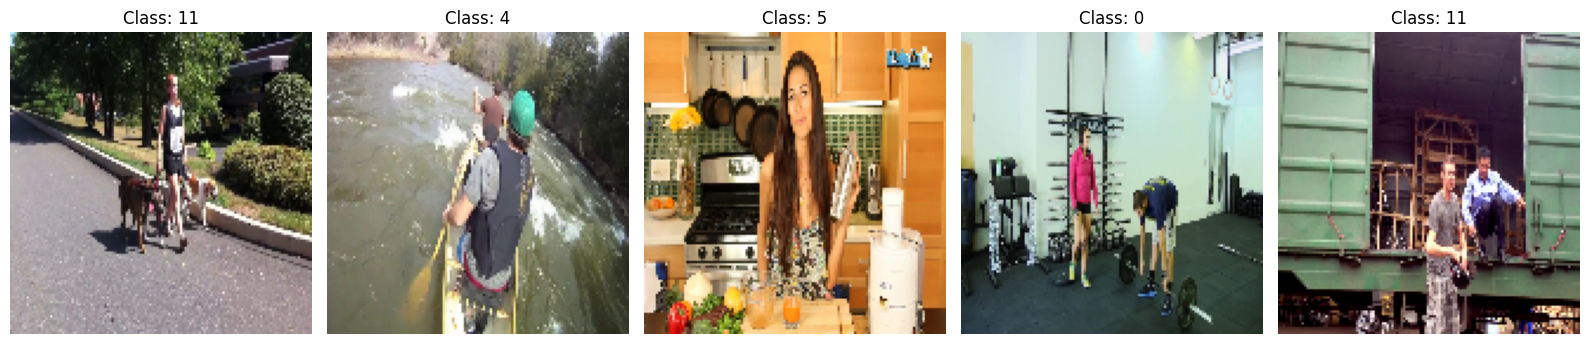

In [51]:
def showImages(count_size):
    plt.figure(figsize=(16, 16))
    
    for i in range(count_size):
        random_idx = np.random.randint(0, X_train.shape[0])
        
        plt.subplot(1, count_size, i+1)
        plt.imshow(X_train[random_idx])
        plt.title(f"Class: {y_train[random_idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

showImages(5)

In [65]:
X_train_tensor = torch.from_numpy(X_train.transpose(0, 3, 1, 2)).float()
y_train_tensor = torch.from_numpy(y_train).long() 

data = TensorDataset(X_train_tensor, y_train_tensor)

train_size = int(0.7 * len(data))
val_size = len(data) - train_size
dataset_train, dataset_val = random_split(data, [train_size, val_size])

BATCH_SIZE = 64
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

batch_images, batch_labels = next(iter(train_loader))
print(f"Размер батча изображений: {batch_images.shape}")
print(f"Размер батча меток: {batch_labels.shape}")

Размер батча изображений: torch.Size([64, 3, 128, 128])
Размер батча меток: torch.Size([64])


In [66]:
def show_losses(train_loss, test_loss):
    clear_output()

    plt.figure(figsize=(16,8))

    plt.plot(np.arange(len(train_loss)), np.array(train_loss),color="b",label="Тренировочная выборка")
    plt.grid()

    plt.plot(np.arange(len(test_loss)), np.array(test_loss),color="r",label="Тестовая выборка")
    plt.title("Loss values")
    plt.grid()

    plt.legend()

    plt.show()

def run_epoch(model, dataloader, loss_function, optimizer=None):
    total_loss = 0
    
    model.train() if optimizer is not None else model.eval()
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X.float())
            loss = loss_function(pred, y)
            total_loss += loss.item()
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    return total_loss / len(dataloader)
    
def start_learning(count_epochs, model, data_train, data_test, loss_function, optimizer):
    train_loss_hist = []
    test_loss_hist = []
    
    best_loss = float('inf')
    best_model_weights = None
    
    for i in range(count_epochs):
        train_loss = run_epoch(model, data_train, loss_function, optimizer)
        test_loss = run_epoch(model, data_test, loss_function)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                                                optimizer, 
                                                mode='min', 
                                                factor=0.5, 
                                                patience=3
                                            )

        scheduler.step(test_loss)
        
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')
        
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        
        show_losses(train_loss_hist, test_loss_hist)
    
    # Загружаем веса лучшей модели
    model.load_state_dict(best_model_weights)
    return test_loss_hist

In [67]:
class BestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc1 = nn.Linear(512*4*4, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 340)
        self.bn2 = nn.BatchNorm1d(340)
        self.drop2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(340, 340)
        self.bn3 = nn.BatchNorm1d(340)
        self.drop3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(340, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.drop4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(64, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.drop5 = nn.Dropout(0.5)

        self.fc6 = nn.Linear(64, 15)
        self.flat = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.flat(self.conv(x))
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.drop3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.drop4(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.drop5(x)

        x=self.fc6(x)
        return x

In [68]:
model = BestModel().to(device)
summary(model, input_size=(3, 128, 128))

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

NUM_EPOCHS=2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         147,584
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
             ReLU-14          [-1, 256,

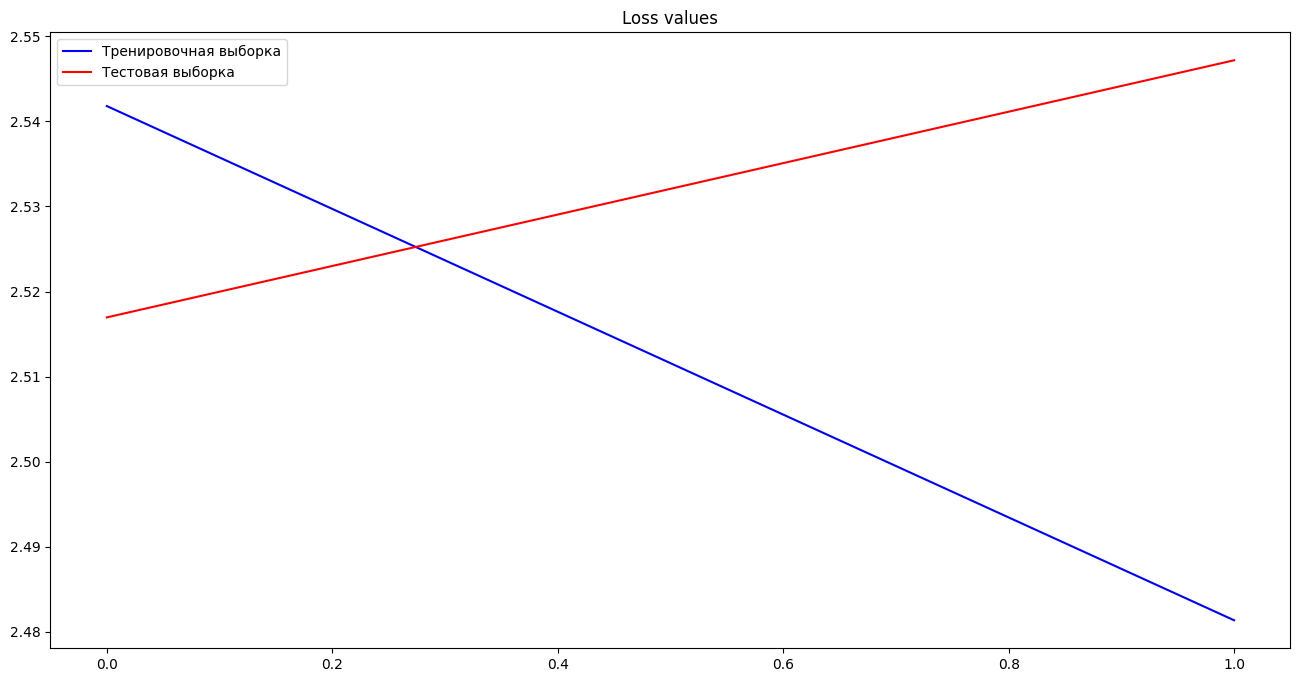

Минимальный лосс при обучении: 2.516957846181146


In [69]:
test_loss_hist_model1=start_learning(NUM_EPOCHS,model,train_loader,val_loader,loss_function,optimizer)
print(f"Минимальный лосс при обучении: {min(test_loss_hist_model1)}")

In [54]:
class BestModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Свёрточные блоки с skip-connection
        self.conv = nn.Sequential(
            # Первый блок (без skip)
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Блок с skip-connection
            nn.Sequential(
                nn.Conv2d(32, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Residual блоки для 128 каналов
            self._make_residual_block(64, 128),
            self._make_residual_block(128, 128),
            self._make_residual_block(128, 128),
            
            # Residual блоки для 256 каналов
            self._make_residual_block(128, 256, downsample=True),
            self._make_residual_block(256, 256),
            
            # Residual блоки для 512 каналов
            self._make_residual_block(256, 512, downsample=True),
            self._make_residual_block(512, 512),
            
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten()
        )

        # Полносвязная часть (без изменений)
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 340)
        self.bn2 = nn.BatchNorm1d(340)
        self.drop2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(340, 340)
        self.bn3 = nn.BatchNorm1d(340)
        self.drop3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(340, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.drop4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(64, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.drop5 = nn.Dropout(0.5)

        self.fc6 = nn.Linear(64, 15)

    def _make_residual_block(self, in_channels, out_channels, downsample=False):
        layers = []
        stride = 2 if downsample else 1
        
        # Основная ветвь
        layers.append(nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, 3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))

        # Skip connection
        skip = []
        if in_channels != out_channels or downsample:
            skip.append(nn.Conv2d(in_channels, out_channels, 1, stride=stride))
            skip.append(nn.BatchNorm2d(out_channels))
        
        return ResidualBlock(nn.Sequential(*layers), nn.Sequential(*skip))

    def forward(self, x):
        x = self.conv(x)
        
        # Полносвязная часть (без изменений)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.drop3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.drop4(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.drop5(x)

        x = self.fc6(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, main_branch, skip_branch=None):
        super().__init__()
        self.main = main_branch
        self.skip = skip_branch if skip_branch else nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.main(x)
        return F.relu(out + identity)

In [55]:
model = BestModel().to(device)
summary(model, input_size=(3, 128, 128))

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                      lr=0.001, 
                      weight_decay=1e-5)

NUM_EPOCHS=50

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          36,928
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
        MaxPool2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]           8,320
      BatchNorm2d-12          [-1, 128, 32, 32]             256
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

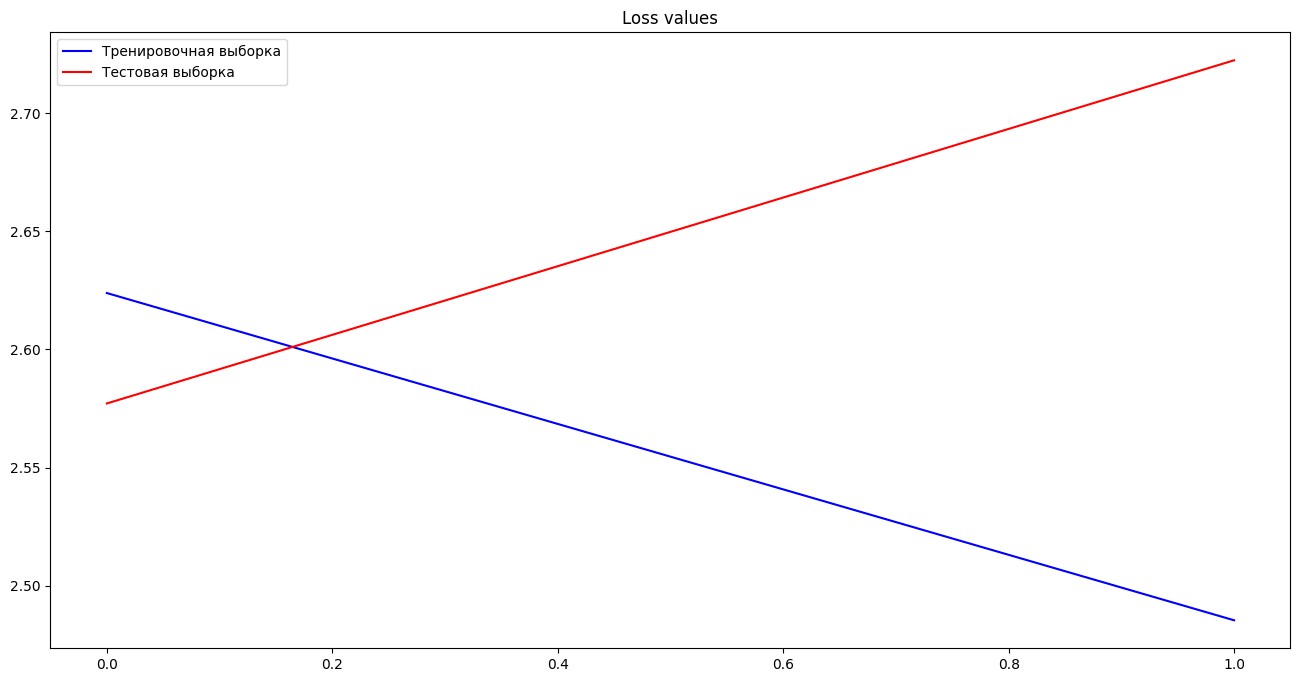

  6%|▌         | 10/165 [00:32<08:26,  3.27s/it]


KeyboardInterrupt: 

In [56]:
test_loss_hist_model1=start_learning(NUM_EPOCHS,model,train_loader,val_loader,loss_function,optimizer)
print(f"Минимальный лосс при обучении: {min(test_loss_hist_model1)}")